# 유방암 판별 예측

## 패키지 로딩 

In [27]:
from sklearn.datasets import load_breast_cancer # 데이터
from sklearn.linear_model import LogisticRegression # 로지스틱 모델
from sklearn.preprocessing import StandardScaler # 전처리 : 스케일링
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, plot_roc_curve
# 성능 평가 roc_curve : 커브 그리기 / roc_auc_score : 면적 구하기 / confusion_matrix : 혼동행렬 / plot_roc_curve : 커브 그래프 그리기
from sklearn.model_selection import train_test_split # 학습/평가용 분할

import numpy as np
import pandas as pd

## 데이터 로드 및 확인

In [5]:
breast = load_breast_cancer()
# print(breast.DESCR)
df = pd.DataFrame(breast.data, columns=breast.feature_names)
df['class'] = breast.target
df.head()
print(df['class'].value_counts())
# 0 악성종양 (암) / 1 양성종양 (암이 아님)

1    357
0    212
Name: class, dtype: int64


## 데이터 준비

In [6]:
x = breast.data
y = breast.target
x.shape, y.shape

((569, 30), (569,))

## 데이터 스케일링

In [8]:
scaled_x = StandardScaler().fit_transform(x)

## 학습 데이터와 평가 데이터 분리

In [10]:
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.3, stratify=y) # 랜덤하게 데이터를 가져오다보니 아래의 학습 결과는 다를 수 있음

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((398, 30), (398,), (171, 30), (171,))

## 모델 생성
- 회귀계수 최적화 옵션

    - 1. solver: 최적화 문제에 사용될 알고리즘 (어떤 알고리즘으로 수행할 것인지 종류를 기재)
        - 'lbfgs' : solver 기본값 / CPU 코어 수가 많다면 최적화를 병렬로 수행.
        - 'liblinear' : 국소 최적화(local minimum) 문제가 있고, 병렬 최적화를 수행할 수 없다.
            - 국소 최적화 문제 : 다차원 변수의 함수의 경우 종모양이 아니라 곡선의 형태인데, loss가 최저인 global minimum가 아닌 local minimum에 빠져버려 더이상 최적의 weight를 찾지 못하는 것
            - 병렬 최적화 수행 불가 : 멀티코어를 활용하지 못함. (1. 예전에 PC의 코어가 하나였을 때는 C분할을 통해 유한한 시간을 잘게 쪼개었다. ex) 첫 작업 1초 실행하고 내려와. 그 다음 작업 1초 실행하고 내려와. -> 1초를 무한히 작게 쪼개면, 마치 동시에 실행되는 것처럼 보임) (2. 현재는 코어가 8-10개 들어가있어 동시다발적으로 실행 가능 - 멀티태스킹)
        - 'sag', 'saga' : 확률적 경사하강법을 기반으로 한 알고리즘으로 대용량 데이터에 적합
            - 일반 경사하강법 : 매번 오차함수를 적용하므로 w 업데이트 시간이 오래 걸림
            - 확률적 경사하강법 : 데이터를 랜덤 샘플링하여 w를 어떻게 업데이트할 지 정함
        - 'newton-cg' : 멀티클래스 분류 모델에 사용
    - 2. solver에 따른 규제 지원 사항
        - newton-cg, lbfgs, sag : L2
        - liblinear, saga : L1, L2
        - C : 규제 강도의 역수 (선형모델에서는 alpha 값을 사용했고, LogisticRegression과 같이 분류 모델에서는 C를 사용한다. alpha값이 클수록, C값이 작을수록 모델이 단순해진다.)
    - 3. max_iter : solver가 수렴하는데 필요한 반복 횟수 (default: 100)
        - solver가 수렴 : 최적의 w를 찾는 것
        - 최적의 w를 찾기 전에 iteration이 먼저 끝나면 max_iter 값을 크게 수정해야함.

In [12]:
model = LogisticRegression()
model.fit(x_train, y_train)

print('추정계수(가중치): ', model.coef_)
print('절편: ', model.intercept_)

추정계수(가중치): [[-0.37848305 -0.59158682 -0.35563138 -0.40632574 -0.37049187  0.27015107
  -0.69226035 -0.9319424   0.39466735  0.14133819 -1.36282504  0.11555166
  -0.69904692 -0.86444872 -0.14719793  0.68649018  0.25928556 -0.3811895
   0.22516549  0.41348484 -0.92401571 -0.99211783 -0.70200376 -0.81027399
  -0.82871442 -0.05674246 -0.65716554 -0.77375151 -0.79940687 -0.4576026 ]]
절편:  [0.0382254]


## 모델 예측

In [13]:
y_hat = model.predict(x_test)
print('예측값: ', y_hat[:20])
print('실제값: ', y_test[:20])

예측값:  [0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1]
실제값:  [1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 1]


## Confusion Matrix (혼동행렬 함수)
- 행을 true값 (실제상황) / 열을 predict값 (예측상황)으로 이용
    - 기존 교안에서는 행과 열이 반대였음
- 양성과 음성의 구분은 별도의 레이블을 지정하지 않으면 레이블 값의 정렬된 순서로 사용한다.
    - label값(y값)이 0과 1로 정렬되어있을 때, 0을 negative 음성종양으로 1을 positive 양성종양으로 쓴다. (원래는 0 악성종양 (암) / 1 양성종양 (암이 아님))
    
<pre>
                             Predict
----------------------------------------------------------
             N (0 음성종양)     |     P (1 양성종양)
----------------------------------------------------------
   |    |                       |
   |  N |          TN           |         FP
T  |    |                       |
R  |------------------------------------------------------  
U  |    |                       |
E  |  P |          FN           |         TP
   |    |                       |
----------------------------------------------------------

</pre>

In [15]:
matrix = confusion_matrix(y_test, y_hat)
print(matrix)

[[ 62   2]
 [  2 105]]


## 평가지표

In [24]:
np.set_printoptions(suppress=True, precision=2)
# 정밀도를 소수점 세 자리까지 보여줌

In [28]:
accuracy = accuracy_score(y_test, y_hat)
print(f'정확도: {accuracy:.3f}') # (62+105) / (62+2+2+105) # (TN+TP) / (전체)
precision = precision_score(y_test, y_hat)
print(f'정밀도: {precision:.3f}') # (105) / (2+105) # TP / (FP+TP)
recall = recall_score(y_test, y_hat)
print(f'재현율: {precision:.3f}') # (105) / (2+105) # TP / (FN+TP)


# roc_auc_score
pred_proba_positive = model.predict_proba(x_test)[:, 1] # 모든 행의 1열
# print(pred_proba_positive)
# negative로 예측할 확률 0.51, positive로 예측할 확률 0.49 => 0으로 예측한 것
# 확률분포의 값이 큰 것을 최종 예측 결과로 내는 것
# [:, 1] : 모든 행의 1열 (positive만 슬라이싱한 것)

auc = roc_auc_score(y_test, pred_proba_positive)
print(f'AUC:{auc:.3f}')
# 첫 번째 매개변수 : y_test : 실제값을 전달하는 것은 동일
# 두 번째 매개변수 : y_hat(예측값)이 아닌 positive로 예측한 확률값을 전달
# positive로 예측한 확률값 / 예측하고자하는 x값을 전달하면 확률값을 보여준다.

# AUC:0.995 : 1에 가까우므로 좌측 상단 꼭짓점을 가득채운 직사각형 모형의 커브 곡선이 생길 것

정확도: 0.977
정밀도: 0.981
재현율: 0.981
AUC:0.995


C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


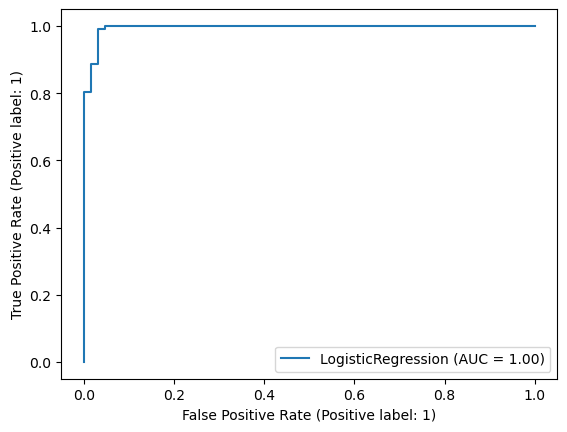

In [31]:
# from sklearn.metrics import plot_roc_curve # 커브 그래프 그리기
import matplotlib.pyplot as plt

plot_roc_curve(model, x_test, y_test)
plt.show()
# 거의 직사각형에 가까운 그림이 그려짐

## solver별 성능 평가 및 비교하기

In [36]:
solvers=['lbfgs','liblinear','newton-cg','sag','saga']

for solver in solvers:
    model=LogisticRegression(solver=solver, max_iter=600) # DEFAULT는 100이지만 600번 학습하도록 함
    model.fit(x_train, y_train)
    y_hat=model.predict(x_test)
    
    print(f'solver : {solver}, accuracy : {accuracy_score(y_test, y_hat):.3f}, auc : {roc_auc_score(y_test,pred_proba_positive):.3f}')

solver : lbfgs, accuracy : 0.977, auc : 0.995
solver : liblinear, accuracy : 0.977, auc : 0.995
solver : newton-cg, accuracy : 0.977, auc : 0.995
solver : sag, accuracy : 0.977, auc : 0.995
solver : saga, accuracy : 0.977, auc : 0.995


## 예측 확률
- 각 레코드(사례)별 개별 클래스 예측 확률값 반환
- 분류 임계값: 0.5 (넘으면 1, 넘지 못하면 0)

In [37]:
prob = model.predict_proba(x_test)
prob_df = pd.DataFrame(prob[:10], columns=['negative(0)', 'positive(1)'])
prob_df
# 두 개 확률의 합은 1
# 첫 번째 레코드 : 0을 선택할 확률 0.509202 / 1을 선택할 확률 0.490798 -> 0선택

,negative(0),positive(1)
0,0.509202,0.490798
1,0.000132,0.999868
2,0.559416,0.440584
3,0.016178,0.983822
4,0.000813,0.999187
5,0.033360,0.966640
6,0.985935,0.014065
7,0.000208,0.999792
8,0.000002,0.999998
9,0.052615,0.947385


# 대출 가능여부 예측
- 0 negative 대출 불가능 / 1 positive 대출 가능

## 패키지 로딩

In [65]:
from sklearn.linear_model import LogisticRegression # 로지스틱 모델
from sklearn.preprocessing import StandardScaler # 전처리 : 스케일링
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, plot_roc_curve
# 성능 평가 roc_curve : 커브 그리기 / roc_auc_score : 면적 구하기 / confusion_matrix : 혼동행렬 / plot_roc_curve : 커브 그래프 그리기
from sklearn.model_selection import train_test_split # 학습/평가용 분할

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 데이터 로드 및 확인

In [67]:
import numpy as np
import pandas as pd

loan_origin = pd.read_csv('Personal_Loan.csv')
loan_origin.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [69]:
loan_origin.shape

(5000, 14)

In [70]:
loan_origin.info()
# RangeIndex : 전체 레코드의 개수 5000개
# Non-Null Count : 5000 non-null이므로 결측치 없음
# Dtype : 모두 숫자형 : int와 float

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


## 데이터 전처리
- 불필요한 컬럼 삭제 : ID, Zip Code

In [71]:
# 카피본 떠놓고 시작하기
loan = loan_origin.copy()
loan.drop(['ID', 'ZIP Code'], axis=1, inplace=True)
loan.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


## 데이터 준비 (독립변수와 종속변수 분리)
- 종속변수 : 'Personal Loan'
- 독립변수 : 나머지

In [72]:
x = loan.drop('Personal Loan', axis=1)
y = loan['Personal Loan']
print(y.value_counts()) # y의 유니크값 분포 보기

0    4520
1     480
Name: Personal Loan, dtype: int64


## 학습 / 평가용 데이터 분할

In [87]:
from sklearn.model_selection import train_test_split # 학습/평가용 분할

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.3,
                                                    stratify=y)
# stratify=y : 분류마다 1:1 비율에 따라 추출해야하므로 분류데이터에서는 무조건사용해야함
# 랜덤하게 데이터를 가져오다보니 아래의 학습 결과는 다를 수 있음
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3500, 11), (3500,), (1500, 11), (1500,))

## 모델 생성 및 학습
**로지스틱 회귀계수의 해석**
- 로지스틱 모델에서는 분류의 기준이 확률값으로 만들어지다보니 선형회귀식을 시그모이드함수로 만들기 위해 y값을 odds에 log함수를 취해 변환하여 만들었다.
- 따라서 로지스틱 회귀계수에서 지수변환 (exp()을 각각의 가중치에 취함)을 해주면 다시 odds비가 나오므로 각 가중치가 의미하는 바를 명확히 알 수 있다.
- odd비 = 성공 확률 / 실패 확률
- 대출여부에 영향을 미치는 A 변수(ex. 교육수준)의 오즈비가 1보다 큰 경우, 대출 승인 확률이 높다는 의미
- 만약 오즈비가 1이라면 대출 거부 확률과 대출 승인 확률이 비슷하다는 의미
- 만약 오즈비가 5라면 대출 거부 확률보다 대출 승인 확률이 5배 높다는 의미

In [88]:
from sklearn.linear_model import LogisticRegression # 로지스틱 모델

model = LogisticRegression(max_iter=2000) # max_iter=2000 : 반복학습 횟수
model.fit(x_train, y_train)

coef = model.coef_.squeeze(axis=0)
print('추정계수(가중치): ', coef) # 각 컬럼(독립변수)마다의 가중치
# suqeeze : 2차원 행렬 (1,13) -> 1차원 벡터 (13,) : 행 축을 없애야하므로 axis=0

# 현재 종속변수 y는 확률분포 값이므로 (-int, inf) 지수변환을 하면 odds비가 나옴.
# 성공 = 대출 승인 / 실패 = 대출 거부
# 각 feature마다 대출 승인 받는데에 있어서 대출승인/대출거부 비율이 얼마나 영향을 미치는지 알 수 있다.
odds_rate = np.exp(model.coef_).squeeze(axis=0) # 가중치에 지수함수 씌운 것 
coef_df = pd.DataFrame({'가중치': coef, 'Odds비':odds_rate}, index=x.columns)
print(coef_df)

# odds비가 1보다 큰 경우에는 대출 승인 확률이 높다는 의미
# odds비가 5인 경우에는 대출 승인 확률이 대출 거부 확률의 5배라는 의미
# Age 0.91170 : 나이가 커질수록 대출 거절 확률이 높다.
# Education 5.815160 :교육수준이 커질수록 대출 승인 확률이 높다.

print('절편: ', model.intercept_)

추정계수(가중치):  [-0.04  0.05  0.05  0.71  0.13  1.72  0.   -0.42  3.07 -0.66 -0.78]
                         가중치      Odds비
Age                -0.039484   0.961286
Experience          0.053316   1.054763
Income              0.054253   1.055752
Family              0.709582   2.033142
CCAvg               0.133849   1.143220
Education           1.721383   5.592258
Mortgage            0.000366   1.000366
Securities Account -0.416448   0.659385
CD Account          3.074974  21.649315
Online             -0.661919   0.515860
CreditCard         -0.777025   0.459772
절편:  [-12.61]


## 모델 예측

In [89]:
y_hat = model.predict(x_test)
print('예측값: ', y_hat[:20])
print('실제값: ', y_test.values[:20]) # values : Series -> 값만 출력하기 위함

예측값:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
실제값:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


## 모델 성능 측정 및 평가

In [93]:
cf = confusion_matrix(y_test, y_hat)
cf_df = pd.DataFrame(cf, columns=[['predict', 'predict'],['대출 불허(0)', '대출 승인(1)']], index=[['actual', 'actual'],['대출 불허(0)', '대출 승인(1)']])
# 이중 리스트를 이용한 멀티 인덱스 지정
display(cf_df)

# Confusion Matrix (혼동행렬 함수)
# 양성과 음성의 구분은 별도의 레이블을 지정하지 않으면 레이블 값의 정렬된 순서로 사용한다.
# label값(y값)이 0과 1으로 정렬되어있으므로, 0을 negative 대출 불가능으로 1을 positive 대출 가능으로 쓴다. (원래도 0 neg 대출 불가능 / 1 pos 대출 가능)

predict         
                대출 불허(0) 대출 승인(1)
actual 대출 불허(0)     1334       22
       대출 승인(1)       48       96

In [53]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, plot_roc_curve
# 성능 평가 roc_curve : 커브 그리기 / roc_auc_score : 면적 구하기 / confusion_matrix : 혼동행렬 / plot_roc_curve : 커브 그래프 그리기
np.set_printoptions(suppress=True, precision=2)
# 정밀도를 소수점 세 자리까지 보여줌


In [ ]:
print(f'정확도: {accuracy_score(y_test, y_hat):.3f}') # (TN+TP) / (전체)
print(f'정밀도: {precision_score(y_test, y_hat):.3f}') # TP / (FP+TP)

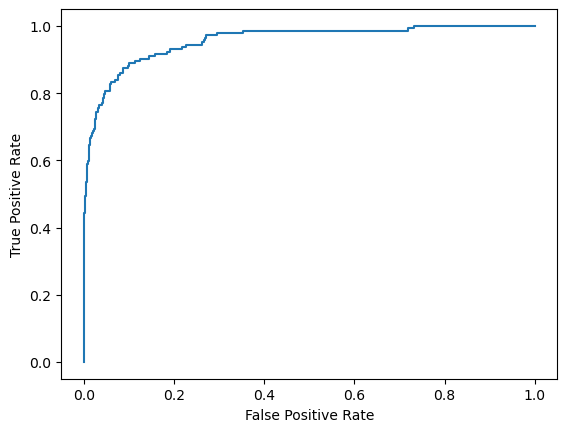

In [95]:
# 시각화
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:, 1])
# roc_curve : 임계값에 따른 거짓양성률, 참양성률을 반환
# model.predict_proba(x_test)[:, 1] # 모든 행의 1열 (positive만 슬라이싱한 것)
# y_hat(예측값)이 아닌 positive로 예측한 확률값을 전달
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [96]:
# 수치 확인 : roc_auc_score
auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
print(f'AUC:{auc:.3f}')
# 첫 번째 매개변수 : y_test : 실제값을 전달하는 것은 동일
# 두 번째 매개변수 :  : y_hat(예측값)이 아닌 positive로 예측한 확률값을 전달

# AUC:0.957 : 1에 가까우므로 좌측 상단 꼭짓점을 가득채운 직사각형 모형의 커브 곡선이 생긴 것

AUC:0.957


## 교차검증

In [105]:
# 평가지표 종류 알아보기
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [109]:
# 분류문제니까 StratifiedKFold 써도 되고, 간단하게 cross_validate 써도 됨
from sklearn.model_selection import cross_val_score, cross_validate

# cross_validate() : cross_val_score()와 유사
# 차이점1 : 매 검증마다 소요된 학습 시간과 검증 시간을 딕셔너리로 반환한다.
# 차이점2 : 여러가지 평가지표를 리스트 형태로 전달 가능 (회귀모델의 평가지표에 MAE, RMSE, R스퀘어가 있듯이, 분류모델의 평가지표에는 정확도, 정밀도, AUC, F1 등이 있다)

model = LogisticRegression(max_iter=2000) # max_iter=2000 : 반복학습 횟수
model.fit(x_train, y_train)

scores = cross_validate(model, x, y, cv=10, scoring=['accuracy', 'precision', 'roc_auc'])
# cv : 교차검증 횟수 (DEFAULT는 5회)
# scoring : 평가지표의 이름을 리스트로 전달
# accuracy 정확도 / precision 정밀도 / roc_auc
# 결과가 딕셔너리 형태로 넘어온다.


for key, val in scores.items():
    # 딕셔너리 객체로 반환된 result를 items 함수를 통해 key와 value를 모두 받기
    print('평가지표: ', key)
    print(f'평균값: {np.mean(val):.2f}')
    # 교차검증마다의 평가지표가 아닌 전체 평가지표의 평균만 알면 되니까
    print('-'*30)

# fit_time : 학습시간
# score_time : 검증시간
# 나머지 : 1에 가까울 수록 좋다.

평가지표:  fit_time
평균값: 0.45
------------------------------
평가지표:  score_time
평균값: 0.00
------------------------------
평가지표:  test_accuracy
평균값: 0.95
------------------------------
평가지표:  test_precision
평균값: 0.81
------------------------------
평가지표:  test_roc_auc
평균값: 0.96
------------------------------


In [ ]:
# self) StratifiedKFold 쓴다면?

In [104]:
from sklearn.model_selection import KFold, StratifiedKFold # 교차검증
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate # cross_val_score, cross_validate : 교차검증 함수
from sklearn.tree import DecisionTreeClassifier # 분류 문제를 해결하기 위한 모델 객체 (Linear Regression과 비슷한 것)
from sklearn.metrics import accuracy_score # 분류 모델 성능 측정용 : 분류 문제 관련한 모형들에 대한 검증 방법 중 하나가 얼마나 분류를 잘 했는지를 보는 것임

In [100]:
k_fold = StratifiedKFold(n_splits=5)
x = loan.drop('Personal Loan', axis=1)
y = loan['Personal Loan']
k = 0 # 교차검증 횟수
cv_acc = [] # cross validation accuracy : 교차 검증마다의 정확도를 저장하는 리스트

model = DecisionTreeClassifier(random_state=1) # 모델 생성
# random_state=1 : 의사결정나무(DecisionTreeClassifier)를 생성할 때, 나무에 사용할 샘플 데이터를 추출한다. 이때 랜덤 추출되는 샘플 데이터의 seed 값을 고정한 것

for train_index, test_index in k_fold.split(x, y):
    # 매개변수에 독립변수 뿐만 아니라 종속변수도 넣어줘야, 모든 데이터를 똑같은 비율로 나눌 수 있다.
    # k_fold.split(x, y) : 총 150개의 데이터는 3개 품종이므로 ABC의 그룹이라고 가정하고, 그것을 (n_splits=5이므로) 5개로 나누어 순서대로 abcde그룹이라고 가정해보자 (ABC는 각 50개 / abcde 그룹은 각 10개)
    # k=1일 때, A그룹의 a, B그룹의 a, C그룹의 a가 test + 나머지는 train
    # k=2일 때, A그룹의 b, B그룹의 b, C그룹의 b가 test + 나머지는 train
    # k=3일 때, A그룹의 c, B그룹의 c, C그룹의 c가 test + 나머지는 train
    # k=4일 때, A그룹의 d, B그룹의 d, C그룹의 d가 test + 나머지는 train
    # k=5일 때, A그룹의 e, B그룹의 e, C그룹의 e가 test + 나머지는 train
    
    # 각 품종별로 5개로 등분 후 학습/평가 그룹으로 나누어진 데이터들의 인덱스 값을 반환하기
    k += 1
    print(f'{k}번째 검증 데이터 세트')
    print('Train: ', train_index)
    print('Test: ', test_index)
    # 학습 데이터와 평가 데이터를 분할하여 가져오기
    x_train, x_test = x[train_index], x[test_index] # 실제 데이터에 인덱싱 
    y_train, y_test = y[train_index], y[test_index] # 실제 데이터에 인덱싱
    
    model.fit(x_train, y_train) # 모델 학습
    y_hat = model.predict(x_test) # 모델 예측
    acc = accuracy_score(y_test, y_hat) # 모델 성능 측정 및 평가 : 정확도
    print(f'{k}번째 교차 검증 정확도: {acc:.2f}')
    cv_acc.append(acc) # 매 교차검증 마다의 평균 정확도를 확인하기 위해 만든 것
    print('-'*30)

print(f'평균 정확도: {np.mean(cv_acc):.2f}')

# stratified k-fold의 평균 정확도가 더 높다!!

1번째 검증 데이터 세트
Train:  [1000 1001 1002 ... 4997 4998 4999]
Test:  [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

KeyError: "None of [Int64Index([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009,\n            ...\n            4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999],\n           dtype='int64', length=4000)] are in the [columns]"

In [103]:
# cross_val_score()
# estimator : 학습에 사용할 모델 객체를 넣어줌
# estimator에 회귀 문제를 해결하기 위한 모델 객체 넣으면 알아서 KFold로 교차검증함
# estimator에 분류 문제를 해결하기 위한 모델 객체 넣으면 알아서 StratifiedKFold로 교차검증함
# x : 독립변수 데이터 셋
# y : 종속변수 데이터 셋
# cv : 교차검증 k 값 (default:5) : 분할하고자하는 fold의 개수


score = cross_val_score(model, x, y)
# cv값 없으므로 DEFAULT인 k=5가 적용됨
# model = DecisionTreeClassifier(random_state=1)
# DecisionTreeClassifier : 분류 문제를 해결하기 위한 모델 객체 (Linear Regression은 회귀 문제 해결용)
# random_state=1 : 의사결정나무(DecisionTreeClassifier)를 생성할 때, 나무에 사용할 샘플 데이터를 추출한다. 이때 랜덤 추출되는 샘플 데이터의 seed 값을 고정한 것
print('score: ', score)
print(f'평균 정확도: {np.mean(score):.2f}')

score:  [0.98 0.98 0.98 0.98 0.98]
평균 정확도: 0.98


In [102]:
# cross_validate() : cross_val_score()와 유사
# 차이점1 : 매 검증마다 소요된 학습 시간과 검증 시간을 딕셔너리로 반환한다.
# 차이점2 : 여러가지 평가지표를 리스트 형태로 전달 가능 (회귀모델의 평가지표에 MAE, RMSE, R스퀘어가 있듯이, 분류모델의 평가지표에는 정확도, 정밀도, AUC, F1 등이 있다)

result = cross_validate(model, x, y, cv=5, scoring=['accuracy', 'precision_macro', 'roc_auc_ovr'])
# scoring : 평가지표의 이름을 리스트로 전달
# accuracy 정확도 / precision_macro 정밀도 / roc_auc_ovr

for key, val in result.items():
    # 딕셔너리 객체로 반환된 result를 items 함수를 통해 key와 value를 모두 받기
    print('평가지표: ', key)
    print(f'평균값: {np.mean(val):.2f}')
    print('-'*30)

# fit_time : 학습시간
# score_time : 검증시간
# 나머지 : 1에 가까울 수록 좋다.

평가지표:  fit_time
평균값: 0.00
------------------------------
평가지표:  score_time
평균값: 0.01
------------------------------
평가지표:  test_accuracy
평균값: 0.98
------------------------------
평가지표:  test_precision_macro
평균값: 0.94
------------------------------
평가지표:  test_roc_auc_ovr
평균값: 0.94
------------------------------


## 교차검증 결과 모델 저장

In [ ]:
# 실생활 적용하기 : 데이터 분석을 통해 잘 학습 및 튜닝된 모델을 만들어 서비스를 구축한 다음 웹 어플리케이션에 붙이기
# 1. 학습이 된 모델을 파일로 저장
# 2. 사용자(고객)가 x_test(자기 정보 13개)를 입력
# 3. predict 함수를 호출 <y_hat = model.predict(x_test)>
# 4. 매개변수인 y_hat(대출 가능 여부)를 반환
# 5. 고객은 반환 결과를 통해 대출 가능 여부를 사전에 체크 가능

In [110]:
import joblib # 모델 학습 결과를 pickle 파일로 저장하기 위한 라이브러리

joblib.dump(model, './lr_model.pkl')
# ./ : 현재 디렉토리
# .pkl : 확장자명

['./lr_model.pkl']

In [111]:
loaded_model = joblib.load('./lr_model.pkl')
# 모델 예측
y_hat = loaded_model.predict(x_test)
print(y_hat[:10])

[0 0 0 0 0 0 0 0 0 0]


# https://www.kaggle.com/
- 지적재산권 저촉되지 않음
- 따라서 expired된 옛날 데이터들이 많고, 상업적으로 민감한 정보는 없음